<a href="https://colab.research.google.com/github/telecombcn-dl/2019-idl-projects/blob/master/team_9/IDL_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Analysis of the performance of different Loss Functions for the MNIST Classification Problem**

*By Roger Benjumea, Ramon Garcia, Miquel Puig, and Biel Tura*

Loss Functions available in Pytorch: https://pytorch.org/docs/stable/nn.html#loss-functions

We'll use PyTorch to define and train a model based on Convolutional Neural Networks for solving the problem. Let's import the PyTorch library along with all its dependencies. Matplotlib will be used for plotting purposes.

In [0]:
#Install libraries if needed
!pip install pillow==5.4.1
!pip install matplotlib
!pip install torch
!pip install torchvision

In [0]:
#Import libraries
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Let's now define the Deep Neural Network that we want to train. We must first, inside the *init constructor*, define the layers that our network will have. For solving the MNIST Classification problem, we'll use two **2D convolutional layers** followed by two **feed-forward layers**.

The first layer is a 2D convolutional layer will handle the input (a B/W image of a digit from the MNIST database, thus an input of 1 channel) and produce an output of 20 channels. The second convolutional layer will handle these 20 channels and output 50 channels. The third layer, a feed-forward one, will handle an input of 4\*4*50 channels and output 500 channels. The fourth layer will deal with it and produce a final output of 10 layers, which matches the possible digits that can predicted (from 0 to 9).

The *forward* method of the class defines the **forward pass**, i.e the actions to be performed at the output of each layer and before the next one. After each convolutional layer, a ReLU (Rectified Linear Unit) activation function is applied, and then a maximum pooling of size 2x2 is performed. After the pooling of the second convolutional layer, the shape of the output tensor is changed, from two dimensions to a single dimension so as that it can be fed to the feed-forward layers. After the first feed-forward layer, a ReLU activation function is applied. Finally, the last layer, after the second feed-forward layer, is a Softmax layer.





In [0]:
class Net(nn.Module):
    def __init__(self):
      #Definition of the layers of the NN
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
      #Definition of activation functions, poolings, intermediate layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

We decided to initialize values on each iteration using *xavier_uniform_* function.

In [0]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

Now, we must define how the Deep Neural Network is trained, which involves defining the **backward pass**.

For the training, different Loss Functions will be used and their results compared. To compare the results, a *losses* vector is defined, so that the loss evolution over training steps will be later plotted for each Loss Function. The LF to be checked are: *l1_loss*, *mse_loss*, *nll_loss*, *cross_entropy*, and *multi_margin_loss* [1].

Both the L1 and the MSE losses are mainly used for regression problems, so the initial expectations are that their performance when used for the MNIST Classification problem will be poor. The L1 loss function is based in computing the least absolute deviation between the output and the ground truth (expected output). The MSE loss function (also called L2 loss), as its name suggests, is based on computing the mean square error between the output and the ground truth.

These functions are mainly used for regression, as explained, and thus are expecting two vectors of the same size, while our NN model is outputting a vector of size 10 with the ordered "probabilities" of the image fed being a digit from 0 to 9, and the ground-truth is just the expected digit (a single number). 

Thus, **an adaptation must be made**, with the aim of converting the ground truth to a vector of 10 elements, where all elements are 0 except the one with the index corresponding to the ground truth digit, which will be 1. This choice of a vector of zeroes and a one is to some extent arbitrary, and changing this criterion may have an impact on the performance of the loss function.

Functions designed for classification purposes (Negative-Log-Likelihood Loss, Cross-Entropy Loss, and Multi-Margin Loss) are already expecting as an input a vector of "probabilities" of 10 elements and the ground truth as a single digit, so no modifications need to be made.

The Cross-Entropy loss functions combines a Negative-Log-Likelihood loss function with a Log-Softmax loss function, and it is thus expected to perform very similarly to the Negative-Log-Likelihood loss functions, but a bit better because of complementing it and boosting high values due to the Softmax.

When researching literature, it has been seen that the problem of determining which loss function is better for a problem, is in general an **empirical problem** [2] (a "try-and-see" problem), with the **Hinge loss function** being the one that **generally performs better** in classification problems [2]. Our study also looks into the Hinge loss function by using the Multi-Margin loss function, which is a Pytorch adaptation of the Hinge loss function for a multi-class classification problem such as the MNIST one.

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch, loss_type):
    losses = [] # Vector to save the losses for each train iteration
    model.train() # let's put the model in training mode
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        #We'll evaluate different loss functions
        if (loss_type is "l1_loss" or loss_type is "mse_loss"):
          #Let's transform the architecture of target appropiately
          #so that it can be used with functions l1_loss and mse_loss,
          #which are normally used for regression problems.
          #target is now a vector of mini-batch length with the ground truth
          #for each mini-batch element. It will be transformed to a tensor,
          #in which each element will be a vector with 0 for all the indexes not
          #corresponding to the ground truth and 1 for the element corresponding to it.
          
          newtarget = []
          for index, element in enumerate(target):
            vector = []
            for i in range(10):
              if (i == element):
                vector.append(1)
              else:
                vector.append(0)
            newtarget.append(vector)
          
          if torch.cuda.is_available():
            newtarget = torch.cuda.FloatTensor(newtarget)
          else:
            newtarget = torch.FloatTensor(newtarget)
        
        if loss_type is "l1_loss":          
          loss = F.l1_loss(output, newtarget)
        elif loss_type is "mse_loss":
          loss = F.mse_loss(output, newtarget)
        elif loss_type is "nll_loss":
          loss = F.nll_loss(output, target)       
        elif loss_type is "cross_entropy":
          loss = F.cross_entropy(output, target)
        elif loss_type is "multi_margin_loss":
          loss = F.multi_margin_loss(output, target)
        #elif loss_type is "cosine_similarity":
          #loss = F.cosine_similarity(...)
        else:
          return

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        #Every once in a while, show the progress of training and the loss 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

Once the model is trained, in order to evaluate its performance, we must devote part of the batch to validation. This part of the batch has not been used for training and the loss must be computed for it, to ensure that no **overfitting** is happening with the training batch, as we could end up having a very low loss and high accuracy for the train examples just because the model had "memorised" in some way the values, without being able to generalise when exposed to different data. The validation batch allows us to detect these overfitting scenarios.

In [0]:
def validate(model, device, loader, loss_type):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            if (loss_type is "l1_loss" or loss_type is "mse_loss"):
              #Let's transform the architecture of target appropiately
              #so that it can be used with functions l1_loss and mse_loss,
              #which are normally used for regression problems.
              #target is now a vector of mini-batch length with the ground truth
              #for each mini-batch element. It will be transformed to a tensor,
              #in which each element will be a vector with 0 for all the indexes not
              #corresponding to the ground truth and 1 for the element corresponding to it.

              newtarget = []
              for index, element in enumerate(target):
                vector = []
                for i in range(10):
                  if (i == element):
                    vector.append(1)
                  else:
                    vector.append(0)
                newtarget.append(vector)

              if torch.cuda.is_available():
                newtarget = torch.cuda.FloatTensor(newtarget)
              else:
                newtarget = torch.FloatTensor(newtarget)
            
            if loss_type is "l1_loss":
              validation_loss += F.l1_loss(output, newtarget, reduction='sum').item()
            elif loss_type is "mse_loss":
              validation_loss += F.mse_loss(output, newtarget, reduction='sum').item()
            elif loss_type is "nll_loss":
              validation_loss += F.nll_loss(output, target, reduction='sum').item()
            elif loss_type is "cross_entropy":
              validation_loss += F.cross_entropy(output, target, reduction='sum').item()
            elif loss_type is "multi_margin_loss":
              validation_loss += F.multi_margin_loss(output, target, reduction='sum').item()
            #elif loss_type is "cosine_similarity":
              #validation_loss += F.cosine_similarity(..., reduction='sum').item()
            else:
              return
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss

Once we have defined our DL model, the training and the validation procedures, we must import the data from the MNIST dataset to later train the model with different Loss Functions and evaluate its performance. For the training, a bacth of 128 data samples is to be used, while 1000 data samples are to be used for the validation.

In [0]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

This is where all computations happen. First, the computation device is defined, and set to a GPU if possible, the model is instantiated to the one that was defined above, and a Stochastic Gradient Descent optimizer (with a learning rate of 0.01 and a momentum of 0.5) is chosen.

For each Loss Function to be studied, the training losses and the validation losses are computed (the way it was defined above in the training and validation methods), for 10 epochs. The result for each Loss Function is then plotted.



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

eval_funcs = ["l1_loss","mse_loss","nll_loss","cross_entropy","multi_margin_loss"]
results = {}
for eval_func in eval_funcs:
  print("############### EVALUATING LOSS FUNCTION "+eval_func+" ###############")
  train_losses = []
  valid_losses = []
  valid_x = []
  num_epochs = 10
  model.apply(init_weights)
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch, eval_func)
      train_losses.extend(epoch_losses) # Training losses (global)
      valid_loss = validate(model, device, valid_loader, eval_func)
      valid_losses.append([valid_loss]) # Validation losses (global)
      valid_x.append(len(train_losses) - 1)
  
  #Save the results of (train and validation losses) of this particular Loss Function
  results[eval_func] = {}
  results[eval_func]['train'] = {}
  results[eval_func]['train']['train_losses'] = train_losses
  results[eval_func]['valid'] = {}
  results[eval_func]['valid']['valid_losses'] = valid_losses
  results[eval_func]['valid']['valid_x'] = valid_x


############### EVALUATING LOSS FUNCTION l1_loss ###############
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.496981
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.409003
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.407439
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.405976
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.405512
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.404979

Validation set: Average loss: 24.0479, Accuracy: 802/10000 (8%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.404958
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.404686
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.404292
Train Epoch: 2 [30720/60000 (51%)]	Loss: 2.404316
Train Epoch: 2 [40960/60000 (68%)]	Loss: 2.404072
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.403846

Validation set: Average loss: 24.0380, Accuracy: 798/10000 (8%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.403825
Train Epoch: 3 [10240/60000 (17%)]	Loss: 2.403630
Train Epoch: 3 [20480/60000 (34%)]	Loss: 2.403588
Train Epoch: 3 [30720/60000 (51%)]	Loss: 2.403561
Train Epoch: 3 [40

In [0]:
#print(results)

Here, the evolution of the train losses for each loss function is plotted. It can be seen that Negative-Log-Likelihood loss, Cross-Entropy loss, and Multi-Margin loss (Hinge loss) functions are the ones that work better.

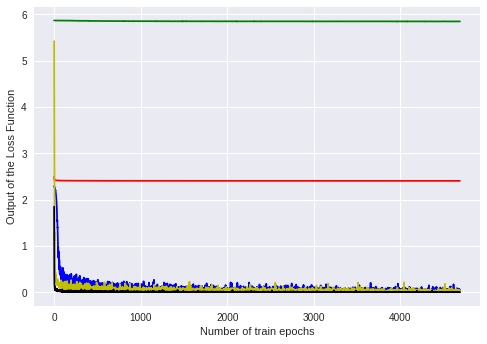

In [0]:
plt.gcf().clear()
plt.ylabel("Output of the Loss Function")
plt.xlabel("Number of train epochs")
plt.plot(results["l1_loss"]["train"]["train_losses"], 'r-')
plt.plot(results["mse_loss"]["train"]["train_losses"], 'g-')
plt.plot(results["nll_loss"]["train"]["train_losses"], 'b-')
plt.plot(results["cross_entropy"]["train"]["train_losses"], 'y-')
plt.plot(results["multi_margin_loss"]["train"]["train_losses"], 'k-')
plt.show()

L1 and MSE loss functions do not behave properly, as it can be seen by the value of the losses they output, and how it varies over time: it is very high and it almost remains unchanged in comparison to other loss functions. This was alread expected: these loss functions are designed for regression problems, not classification ones. Thus, the loss is very high. 

The outputted loss is higher for the MSE loss function than for the L1 but this does not mean that the MSE function is worse. This is explained because the MSE squares the differences, so they are naturally higher in comparison to the absolute value of the differences.

On the contrary, the MSE loss function produces better results than the L1 one, with its achieved accuracy being way higher than the L1 one (95% vs 14%), so it is clearly better -and clearly, the L1 loss function can not be used. Anyway, although the value of the accuracy is quite high, the performance of the MSE is quite worse than the loss functions designed for classifiers, because the MSE converges very slowly in comparison to them, as we will see now.

As it can be seen in the next plots, that show how the loss outputted by the L1 and MSE loss functions evolves over time, it takes a while for the MSE to converge.

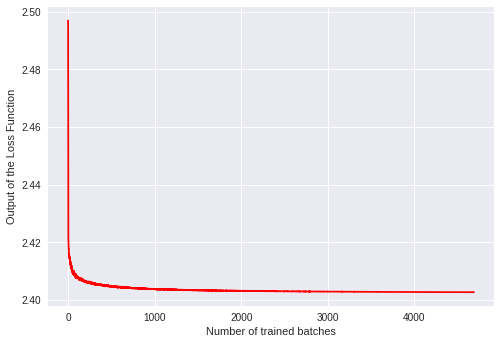

In [0]:
plt.gcf().clear()
plt.ylabel("Output of the Loss Function")
plt.xlabel("Number of trained batches")
plt.plot(results["l1_loss"]["train"]["train_losses"], 'r-')
plt.show()

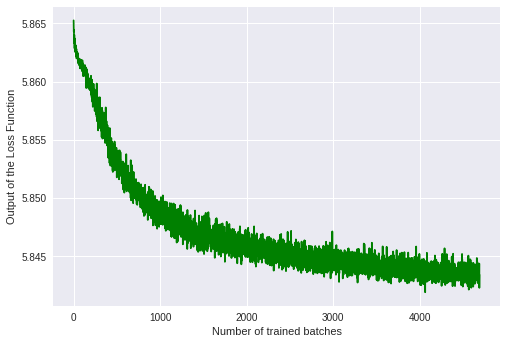

In [0]:
plt.gcf().clear()
plt.ylabel("Output of the Loss Function")
plt.xlabel("Number of trained batches")
plt.plot(results["mse_loss"]["train"]["train_losses"], 'g-')
plt.show()

Next, there is a zoom-in for the loss functions devoted to classification problems (Negative-Log-Likelihood Loss, Cross-Entropy Loss, and Multi-Margin Loss), which clearly work better than the more regression-oriented ones.

First of all, it can be seen that their convergence time is much quicker than the MSE loss function. Also they produce better accuracy (99%), and converge quicker, they are clearly better loss functions.

Comparing them, it can be seen that the Multi-Margin loss function (which is the Hinge loss function adapted for a multi-class classification problem) works the best out of the three, producing a loss with a very low variability. Both Cross-Entropy and Multi-Margin loss converge very quickly, while the Negative-Log-Likelihood loss function needs a bit more of time.

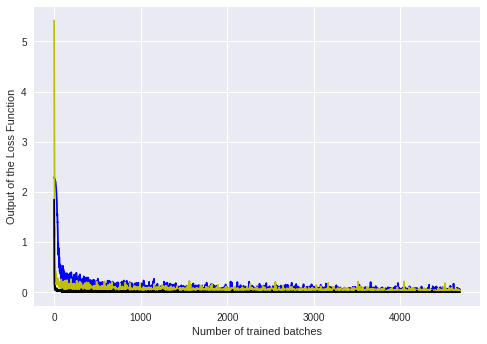

In [0]:
plt.gcf().clear()
plt.ylabel("Output of the Loss Function")
plt.xlabel("Number of trained batches")
plt.plot(results["nll_loss"]["train"]["train_losses"], 'b-')
plt.plot(results["cross_entropy"]["train"]["train_losses"], 'y-')
plt.plot(results["multi_margin_loss"]["train"]["train_losses"], 'k-')
plt.show()

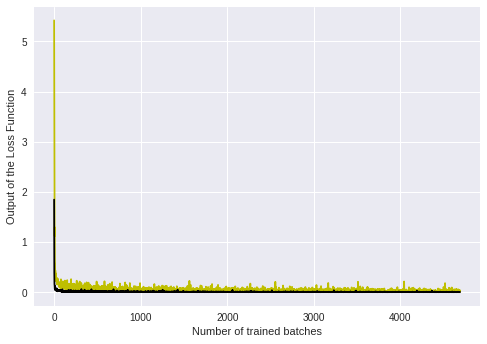

In [0]:
plt.gcf().clear()
plt.ylabel("Output of the Loss Function")
plt.xlabel("Number of trained batches")
plt.plot(results["cross_entropy"]["train"]["train_losses"], 'y-')
plt.plot(results["multi_margin_loss"]["train"]["train_losses"], 'k-')
plt.show()

Let's now plot the same graphs for the validation batch, to ensure that the obtained models were not overfitting on the training batch. Next plot shows that the general behavior of all functions remains the same.


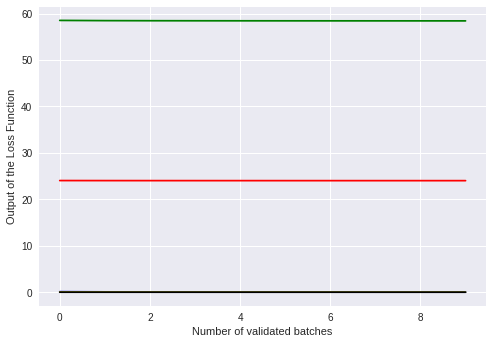

In [0]:
plt.gcf().clear()
plt.ylabel("Output of the Loss Function")
plt.xlabel("Number of validated batches")
plt.plot(results["l1_loss"]["valid"]["valid_losses"], 'r-')
plt.plot(results["mse_loss"]["valid"]["valid_losses"], 'g-')
plt.plot(results["nll_loss"]["valid"]["valid_losses"], 'b-')
plt.plot(results["cross_entropy"]["valid"]["valid_losses"], 'y-')
plt.plot(results["multi_margin_loss"]["valid"]["valid_losses"], 'k-')
plt.show()

As the three classification-oriented loss functions are superposed, lets plot only them three to see the diferences between them. Again, it can be seen that the Multi-Margin loss function works better than the other ones.

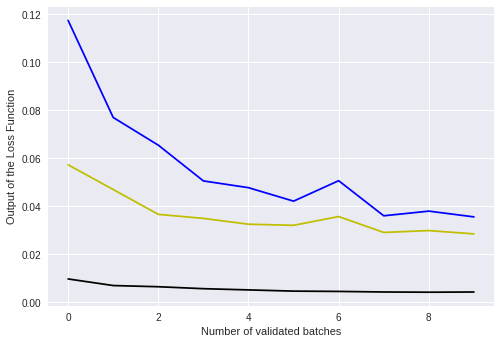

In [0]:
plt.gcf().clear()
plt.ylabel("Output of the Loss Function")
plt.xlabel("Number of validated batches")
plt.plot(results["nll_loss"]["valid"]["valid_losses"], 'b-')
plt.plot(results["cross_entropy"]["valid"]["valid_losses"], 'y-')
plt.plot(results["multi_margin_loss"]["valid"]["valid_losses"], 'k-')
plt.show()

Let's zoom in to the Multi-Margin Loss. It can be seen that it converges very quickly and into the lower loss of all. It also produces a very high (99%) accuracy, so it is clearly the best loss function out of the analysed ones.

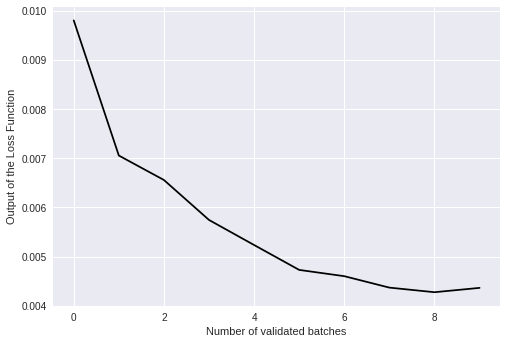

In [0]:
plt.gcf().clear()
plt.ylabel("Output of the Loss Function")
plt.xlabel("Number of validated batches")
plt.plot(results["multi_margin_loss"]["valid"]["valid_losses"], 'k-')
plt.show()

As it was thought when designing the train method and thus choosing the loss functions that were going to be evaluated, this study has shown that:


*   L1 and MSE loss functions (which are regression-oriented) do not perform well (the L1 loss function can not be used because it fails to achieve a proper accuracy, and the MSE offers a good accuracy but takes much more time to converge in comparison to classification-orientd loss functions)
*   The three classification-oriented output a low loss in general and achieve more or less quickly an accuracy of around 99%, from these three functions, the Negative-Log-Likelihood takes a bit more time to converge, and has more variability in the loss
*   Between the Negative-Log-Likelihood and the Cross-Entropy loss functions, the latter is preferred as it converges faster and has less loss variability. They behave very similarly, as it was predicted, though, because the Cross-Entropy function is basically a combination of a Negative-Log-Likelihood function with a Log-Softmax one, so it performs similarly while boosting high values
*   The Hinge loss works best for classification problems (it produces a very low loss, is the faster to converge, also offers 99% accuracy) as literature [1] suggested that it could be shown empirically





[1] Pytorch, Neural Network Loss Functions - https://pytorch.org/docs/stable/nn.html#loss-functions

[2] *Are Loss Functions All the Same?*, L. Rosasco, E. De Vito, A. Camponnetto, M. Piana, A. Verri - http://web.mit.edu/lrosasco/www/publications/loss.pdf